In [3]:
import os
import hydromt
from hydromt import DataCatalog
from hydromt_sfincs import SfincsModel, utils
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs

In [5]:
# Load in model and read results
cat_dir = r'Z:\users\lelise\data'
yml_base_CONUS = os.path.join(cat_dir, 'data_catalog_BASE_CONUS.yml')
yml_base_Carolinas = os.path.join(cat_dir, 'data_catalog_BASE_Carolinas.yml')
yml_sfincs_Carolinas = os.path.join(cat_dir, 'data_catalog_SFINCS_Carolinas.yml')

os.chdir(r'Z:\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor')
model_root = 'ENC_200m_sbg5m_avgN_adv1_eff75'

# Plotting the data on a map with contextual layers
mod = SfincsModel(root=model_root, mode='r', data_libs=[yml_base_CONUS, yml_base_Carolinas, yml_sfincs_Carolinas])
cat = mod.data_catalog

In [7]:
# Load geospatial layers for plotting
l_gdf = cat.get_geodataframe(
    r'Z:\users\lelise\data\geospatial\hydrography\nhd\NHD_H_North_Carolina_State_Shape\Shape\WBDHU6.shp')
l_gdf = l_gdf[l_gdf['Name'].isin(['Pamlico', 'Neuse', 'Onslow Bay', 'Cape Fear', 'Lower Pee Dee'])]
l_gdf.to_crs(epsg=32617, inplace=True)
l_gdf.set_index('Name', inplace=True)
basins = l_gdf

l_gdf = cat.get_geodataframe('carolinas_coastal_wb')
l_gdf.to_crs(epsg=32617, inplace=True)
coastal_wb = l_gdf.clip(basins)

l_gdf = cat.get_geodataframe('carolinas_major_rivers')
l_gdf.to_crs(epsg=32617, inplace=True)
major_rivers = l_gdf.clip(basins)

l_gdf = cat.get_geodataframe(r'Z:\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\hecras_bathy\RAS_point_interpolated\NHDArea_LowerPeeDee.shp')
l_gdf.to_crs(epsg=32617, inplace=True)
lpd_riv = l_gdf.clip(basins)

In [8]:
out_dir = os.path.join(os.getcwd(), model_root, 'validation')
gage_stats = pd.read_csv(os.path.join(out_dir, 'waterlevel', 'hydrograph_stats_by_gageID.csv'))
gage_stats = gpd.GeoDataFrame(gage_stats,
                              geometry=gpd.points_from_xy(x=gage_stats['x'], y=gage_stats['y'], crs=mod.crs))

hwm_locs = pd.read_csv(os.path.join(out_dir, 'hwm', 'hwm_error_all.csv'))
hwm_locs = gpd.GeoDataFrame(hwm_locs,
                            geometry=gpd.points_from_xy(x=hwm_locs['xcoords'], y=hwm_locs['ycoords'], crs=mod.crs))

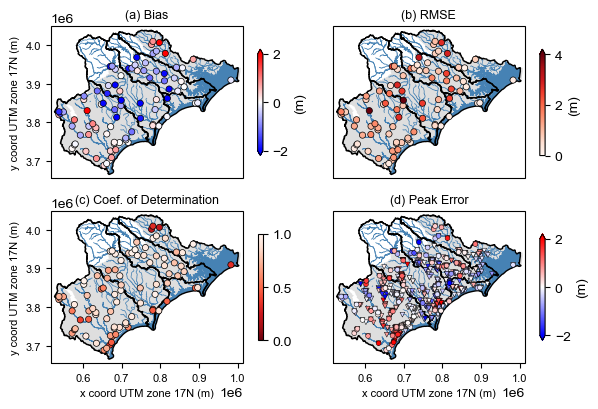

In [9]:
# MAP THE STATS
da = mod.grid['dep']
wkt = da.raster.crs.to_wkt()
utm_zone = da.raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
extent = np.array(basins.buffer(10000).total_bounds)[[0, 2, 1, 3]]

font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})

col = ['bias', 'rmse', 'r2', 'pe']
label = ['(a) Bias', '(b) RMSE', '(c) Coef. of Determination', '(d) Peak Error']
unit = ['(m)', '(m)', '', '(m)']
color_map = ['bwr', 'Reds', 'Reds_r', 'bwr']
n_bins_ranges = [[-2, 2], [0, 4], [0, 1], [-2, 2]]
ext = ['both', 'max', 'neither', 'both']

fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(6.2, 4.2),
    subplot_kw={'projection': utm},
    tight_layout=True
)
axs = axs.flatten()

for i in range(len(col)):
    # Plot background/geography layers
    mod.region.plot(ax=axs[i], color='lightgray', edgecolor='none', linewidth=0, linestyle='-', zorder=2, alpha=0.75)
    coastal_wb.plot(ax=axs[i], color='steelblue', edgecolor='none', linewidth=0, linestyle='-', zorder=2, alpha=1)
    major_rivers.plot(ax=axs[i], color='steelblue', edgecolor='none', linewidth=0.5, linestyle='-', zorder=2, alpha=1)
    lpd_riv.plot(ax=axs[i], color='steelblue', edgecolor='steelblue', linewidth=0.5, linestyle='-', zorder=2, alpha=1)
    basins.plot(ax=axs[i], color='none', edgecolor='black', linewidth=1, linestyle='-', zorder=3, alpha=1)

    # Plot the stat at each gage
    vmax = round(max(n_bins_ranges[i]), 0)
    vmin = round(min(n_bins_ranges[i]), 0)

    if col[i] == 'pe':
        hwm_locs.plot(column='error',
                      cmap=color_map[i],
                      legend=False,
                      vmin=vmin, vmax=vmax,
                      ax=axs[i],
                      markersize=12,
                      marker='v',
                      edgecolor='black',
                      linewidth=0.35,
                      alpha=1,
                      zorder=3
                      )
        gage_stats.plot(column=col[i],
                        cmap=color_map[i],
                        legend=False,
                        vmin=vmin, vmax=vmax,
                        ax=axs[i],
                        markersize=12,
                        edgecolor='black',
                        linewidth=0.35,
                        alpha=1,
                        zorder=3
                        )
    else:
        gage_stats.plot(column=col[i],
                        cmap=color_map[i],
                        legend=False,
                        vmin=vmin, vmax=vmax,
                        ax=axs[i],
                        markersize=20,
                        edgecolor='black',
                        linewidth=0.5,
                        zorder=3
                        )

    #  Setup colorbar and add to plot
    sm = plt.cm.ScalarMappable(cmap=color_map[i], norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(sm,
                 ax=axs[i],
                 shrink=0.7,
                 label=unit[i],
                 extend=ext[i],
                 spacing='uniform')

    # Add title and save figure
    axs[i].set_extent(extent, crs=utm)
    axs[i].set_title(label[i], loc='center', fontsize=9)

    if i == 0:
        axs[i].set_ylabel(f"y coord UTM zone {utm_zone} (m)", fontsize=8)
        axs[i].yaxis.set_visible(True)
        axs[i].xaxis.set_visible(False)
    elif i == 1:
        axs[i].yaxis.set_visible(False)
        axs[i].xaxis.set_visible(False)
    elif i == 2:
        axs[i].set_ylabel(f"y coord UTM zone {utm_zone} (m)", fontsize=8)
        axs[i].yaxis.set_visible(True)
        axs[i].set_xlabel(f"x coord UTM zone {utm_zone} (m)", fontsize=8)
        axs[i].xaxis.set_visible(True)
    elif i == 3:
        axs[i].yaxis.set_visible(False)
        axs[i].set_xlabel(f"x coord UTM zone {utm_zone} (m)", fontsize=8)
        axs[i].xaxis.set_visible(True)

    axs[i].ticklabel_format(style='sci', useOffset=False)
    axs[i].set_aspect('equal')
    axs[i].xaxis.set_tick_params(labelsize=8)
    axs[i].yaxis.set_tick_params(labelsize=8)

plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
#plt.savefig(os.path.join(out_dir, 'map_waterlevel_stats'), bbox_inches='tight',tight_layout=True, dpi=225)
#plt.close()